<a href="https://colab.research.google.com/github/jaybeberry9591/graph_theory_clustering_assignments/blob/main/GMM_on_Crimes_in_Boston.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler

import sklearn.cluster as cluster
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import cluster_optics_dbscan
from sklearn import metrics


In [102]:
import numpy as np
import pandas as pd
from statistics import mode
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import geopandas as gpd
import folium
from folium.plugins import HeatMap

In [103]:
#csv file import and modifying the columns name
df = pd.read_csv("/content/drive/MyDrive/crime_boston.csv",encoding = 'windows-1252')
df.columns = df.columns.str.lower() # changing the columns name to work more easily

In [104]:
df.columns = df.columns.str.lower() # changing the columns name to work more easily

In [105]:
df.duplicated().sum()

23

In [106]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace = True)

In [107]:
df.incident_number.nunique()

282517

In [108]:
df[df.duplicated(['incident_number','offense_code'], keep = False)].head(10)

,incident_number,offense_code,offense_code_group,offense_description,district,reporting_area,shooting,occurred_on_date,year,month,day_of_week,hour,ucr_part,street,lat,long,location
82375,I172090479,3115,INVESTIGATE PERSON,INVESTIGATE PERSON,A1,104,NaN,10/29/2017 16:52,2017,10,Sunday,16,NaN,WASHINGTON ST,42.356486,-71.059281,"(42.35648631, -71.05928145)"
82376,I172090479,3115,Investigate Person,INVESTIGATE PERSON,A1,104,NaN,10/29/2017 16:52,2017,10,Sunday,16,Part Three,WASHINGTON ST,42.356486,-71.059281,"(42.35648631, -71.05928145)"
318722,I152041086-00,2407,Disorderly Conduct,ANNOYING AND ACCOSTING,A1,111,NaN,8/17/2015 13:00,2015,8,Monday,13,Part Two,BOYLSTON ST,42.352368,-71.064543,"(42.35236776, -71.06454338)"
318723,I152041086-00,2407,Disorderly Conduct,ANNOYING AND ACCOSTIN,A1,111,NaN,8/17/2015 13:00,2015,8,Monday,13,Part Two,BOYLSTON ST,42.352368,-71.064543,"(42.35236776, -71.06454338)"
318750,I152026775-00,3115,Investigate Person,INVESTIGATE PERSON,C6,936,NaN,10/19/2015 16:04,2015,10,Monday,16,Part Three,ORTON-MAROTTA WAY,42.338573,-71.055755,"(42.33857289, -71.05575501)"
318751,I152026775-00,3115,INVESTIGATE PERSON,INVESTIGATE PERSON,C6,936,NaN,10/19/2015 16:04,2015,10,Monday,16,NaN,ORTON-MAROTTA WAY,42.338573,-71.055755,"(42.33857289, -71.05575501)"
318794,I152000618-00,1503,Firearm Violations,FIREARM/WEAPON - POSSESSION OF DANGEROUS,B2,308,NaN,7/20/2015 18:48,2015,7,Monday,18,Part Two,BOWER ST,42.319968,-71.087150,"(42.31996758, -71.08715022)"
318795,I152000618-00,1503,Firearm Violations,"WEAPON - OTHER - CARRYING / POSSESSING, ETC",B2,308,NaN,7/20/2015 18:48,2015,7,Monday,18,Part Two,BOWER ST,42.319968,-71.087150,"(42.31996758, -71.08715022)"
318846,I142033219-00,1842,Drug Violation,"DRUGS - POSS CLASS A - HEROIN, ETC.",D4,171,NaN,1/4/2016 17:20,2016,1,Monday,17,Part Two,HARRISON AVE,42.335119,-71.074917,"(42.33511904, -71.07491710)"
318847,I142033219-00,1842,Drug Violation,"DRUGS - POSS CLASS A - HEROIN, ETC.",D4,171,NaN,1/4/2016 17:20,2016,1,Monday,17,Part Two,HARRISON AVE,42.335119,-71.074917,"(42.33511904, -71.07491710)"


In [109]:
df.drop_duplicates(subset= ['incident_number','offense_code'], inplace=True)
df.reset_index(drop=True, inplace = True)

In [110]:
df.duplicated(['incident_number','offense_code'], keep = False).any()

False

In [111]:
# summary of numerical ones
df.describe(include='number')

,offense_code,year,month,hour,lat,long
count,319037.000000,319037.000000,319037.000000,319037.000000,299039.000000,299039.000000
mean,2317.536248,2016.560719,6.609603,13.118121,42.214368,-70.908252
std,1185.310509,0.996299,3.273643,6.294283,2.159892,3.493822
min,111.000000,2015.000000,1.000000,0.000000,-1.000000,-71.178674
25%,1001.000000,2016.000000,4.000000,9.000000,42.297424,-71.097135
50%,2907.000000,2017.000000,7.000000,14.000000,42.325538,-71.077524
75%,3201.000000,2017.000000,9.000000,18.000000,42.348624,-71.062467
max,3831.000000,2018.000000,12.000000,23.000000,42.395042,-1.000000


In [112]:
# summary of categorical ones
df.describe(include=['object']).T

,count,unique,top,freq
incident_number,319037,282517,I162030584,13
offense_code_group,319037,67,Motor Vehicle Accident Response,37132
offense_description,319037,241,SICK/INJURED/MEDICAL - PERSON,18783
district,317272,12,B2,49939
reporting_area,319037,879,,20250
shooting,1019,1,Y,1019
occurred_on_date,319037,232566,6/1/2017 0:00,29
day_of_week,319037,7,Friday,48488
ucr_part,318948,4,Part Three,158534
street,308166,4657,WASHINGTON ST,14191


In [113]:
df.columns

Index(['incident_number', 'offense_code', 'offense_code_group',
       'offense_description', 'district', 'reporting_area', 'shooting',
       'occurred_on_date', 'year', 'month', 'day_of_week', 'hour', 'ucr_part',
       'street', 'lat', 'long', 'location'],
      dtype='object')

In [114]:
df.dropna(subset= ["lat"], how ="any", inplace =True)
df.reset_index(drop=True, inplace = True)

In [115]:
df = df.drop(df[df.lat < 30].index)
df.reset_index(drop=True, inplace = True)

In [116]:
df.dropna(subset= ['district'], how ="any", inplace =True)
df.reset_index(drop=True, inplace = True)

In [117]:
df.reset_index(drop=True, inplace = True) # Reset index, in case I forgot to do it before when deleting rows
df_before_del_col = df.copy() # create a copy of the DF before dropping columns

In [118]:
df.drop('incident_number', axis = 1, inplace = True)
df.drop('offense_code', axis = 1, inplace = True)
df.drop('offense_description', axis = 1, inplace = True)
df.drop('reporting_area', axis = 1, inplace = True)
df.drop('occurred_on_date', axis = 1, inplace = True)
df.drop('year', axis = 1, inplace = True)
df.drop('street', axis = 1, inplace = True)
df.drop('location', axis = 1, inplace = True)

In [119]:
import os
lookup = {
    1: 'Night',
    2: 'Night',
    3: 'Night',
    4: 'Night',
    5: 'Night',
    6: 'Night',
    7: 'Morning',
    8: 'Morning',
    9: 'Morning',
    10: 'Morning',
    11: 'Morning',
    12: 'Morning',
    13:'Afternoon',
    14:'Afternoon',
    15:'Afternoon',
    16:'Afternoon',
    17:'Afternoon',
    18:'Afternoon',
    19:'Evening',
    20:'Evening',
    21:'Evening',
    22:'Evening',
    23:'Evening',
    0:'Evening'
}
for fname in os.listdir('.'):
    df['day_period'] = df['hour'].apply(lambda x: lookup[x])

In [120]:
lookup = {
    12: 'Winter',
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Autumn',
    10: 'Autumn',
    11: 'Autumn'
}
for fname in os.listdir('.'):
    df['season'] = df['month'].apply(lambda x: lookup[x])

In [121]:
lookup = {
    'Monday': 1,
    'Tuesday': 1,
    'Wednesday': 1,
    'Thursday': 1,
    'Friday': 1,
    'Saturday': 0,
    'Sunday': 0,
}
for fname in os.listdir('.'):
    df['weekday'] = df['day_of_week'].apply(lambda x: lookup[x])

In [122]:
df.drop('month', axis = 1, inplace = True)
df.drop('hour', axis = 1, inplace = True)
df.drop('day_of_week', axis = 1, inplace = True)

In [123]:
df.sample(10)

,offense_code_group,district,shooting,ucr_part,lat,long,day_period,season,weekday
39689,Firearm Violations,C11,NaN,Part Two,42.299797,-71.065335,Afternoon,Spring,1
1155,Simple Assault,C6,NaN,Part Two,42.339368,-71.053158,Morning,Summer,1
214316,Auto Theft,C11,NaN,Part One,42.285260,-71.064441,Evening,Spring,1
239976,Investigate Person,A15,NaN,Part Three,42.376365,-71.059874,Morning,Winter,1
44735,Vandalism,C11,NaN,Part Two,42.303388,-71.056962,Afternoon,Spring,1
21007,Simple Assault,C11,NaN,Part Two,42.303576,-71.068808,Evening,Summer,1
192733,Verbal Disputes,B3,NaN,Part Three,42.274422,-71.078889,Afternoon,Summer,1
200184,Investigate Property,D4,NaN,Part Three,42.336766,-71.082051,Afternoon,Summer,1
295833,Larceny,D4,NaN,Part One,42.350597,-71.078810,Afternoon,Summer,0
241134,Investigate Person,B2,NaN,Part Three,42.332962,-71.110419,Afternoon,Winter,0


In [124]:
df.to_csv('df_crimes_cleaned.csv')

In [125]:
df = pd.read_csv('df_crimes_cleaned.csv', sep=",", index_col=0)
df.head()

,offense_code_group,district,shooting,ucr_part,lat,long,day_period,season,weekday
0,Larceny,D14,NaN,Part One,42.357791,-71.139371,Afternoon,Autumn,0
1,Vandalism,C11,NaN,Part Two,42.306821,-71.060300,Evening,Summer,1
2,Towed,D4,NaN,Part Three,42.346589,-71.072429,Evening,Autumn,1
3,Investigate Property,D4,NaN,Part Three,42.334182,-71.078664,Evening,Autumn,1
4,Investigate Property,B3,NaN,Part Three,42.275365,-71.090361,Evening,Autumn,1


In [126]:
df.shape

(297397, 9)

In [127]:
df.dropna(subset= ['ucr_part'], how ="any", inplace =True)
df.reset_index(drop=True, inplace = True)

In [128]:
df.dropna(subset= ['shooting'], how ="any", inplace =True)
df.reset_index(drop=True, inplace = True)

In [129]:
df

,offense_code_group,district,shooting,ucr_part,lat,long,day_period,season,weekday
0,Aggravated Assault,E18,Y,Part One,42.250405,-71.131737,Evening,Summer,1
1,Aggravated Assault,B2,Y,Part One,42.321042,-71.072153,Evening,Summer,1
2,Homicide,B2,Y,Part One,42.315689,-71.089514,Afternoon,Summer,1
3,Ballistics,B2,Y,Part Two,42.315689,-71.089514,Afternoon,Summer,1
4,Aggravated Assault,A15,Y,Part One,42.378085,-71.057841,Evening,Summer,0
...,...,...,...,...,...,...,...,...,...
973,Aggravated Assault,B2,Y,Part One,42.317808,-71.066850,Evening,Summer,0
974,Firearm Violations,B2,Y,Part Two,42.317808,-71.066850,Evening,Summer,0
975,Warrant Arrests,B2,Y,Part Three,42.317808,-71.066850,Evening,Summer,0
976,Aggravated Assault,B2,Y,Part One,42.333584,-71.085543,Evening,Summer,1


In [130]:
df.shape

(978, 9)

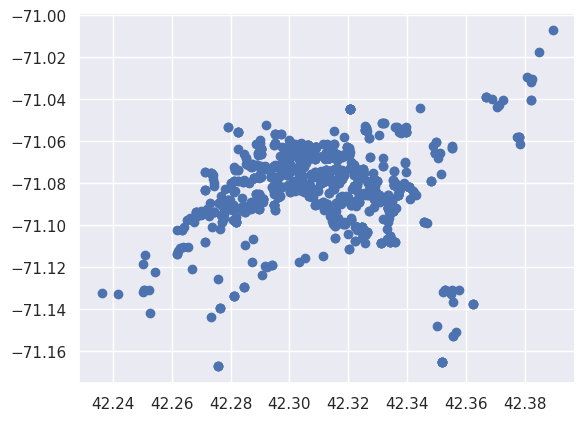

In [131]:
data=df.loc[:,['lat','long']]
plt.scatter(data.lat, data.long)

<function matplotlib.pyplot.show(close=None, block=None)>

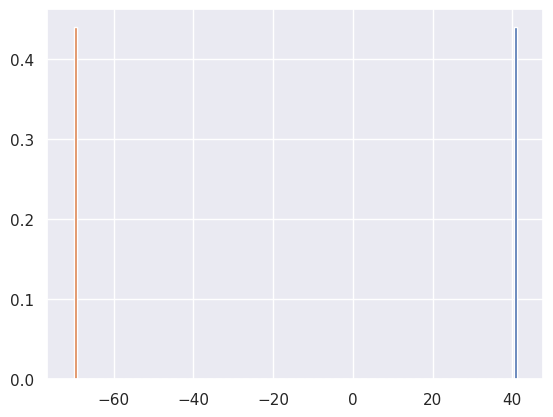

In [132]:
plt.hist(data, bins = 50, density = True)
plt.show

In [133]:
data

,lat,long
0,42.250405,-71.131737
1,42.321042,-71.072153
2,42.315689,-71.089514
3,42.315689,-71.089514
4,42.378085,-71.057841
...,...,...
973,42.317808,-71.066850
974,42.317808,-71.066850
975,42.317808,-71.066850
976,42.333584,-71.085543


In [134]:
data=np.array(data)

In [135]:
data

array([[ 42.2504055 , -71.1317374 ],
       [ 42.32104169, -71.07215291],
       [ 42.3156892 , -71.08951391],
       ...,
       [ 42.31780762, -71.0668499 ],
       [ 42.33358389, -71.08554259],
       [ 42.31161123, -71.076256  ]])

In [136]:
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
scaler= StandardScaler()
sns.set()

In [137]:
# Standardize data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(data)

# Normalizing the Data
normalized_df = normalize(scaled_df)

# Converting the numpy array into a pandas DataFrame
normalized_df = pd.DataFrame(normalized_df)

# Reducing the dimensions of the data
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(normalized_df)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

X_principal.head(2)

,P1,P2
0,-0.575352,0.907248
1,0.520544,-0.762292


In [138]:
gmm = GaussianMixture(n_components = 7)
gmm.fit(X_principal)

GaussianMixture(n_components=7)

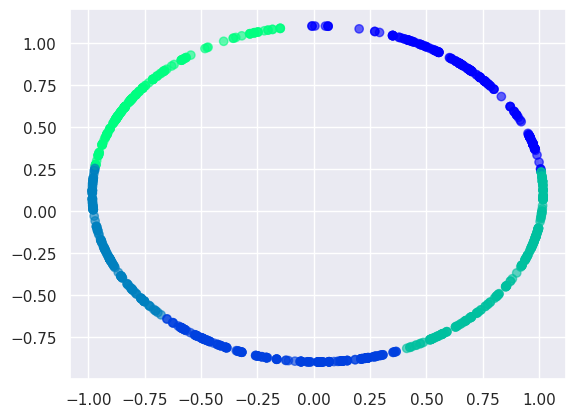

In [139]:
# Visualizing the clustering
plt.scatter(X_principal['P1'], X_principal['P2'],
           c = GaussianMixture(n_components = 5).fit_predict(X_principal), cmap =plt.cm.winter, alpha = 0.6)
plt.show()

In [140]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [141]:
n_clusters=np.arange(2, 8)
sils=[]
sils_err=[]
iterations=20
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(X_principal)
        labels=gmm.predict(X_principal)
        sil=metrics.silhouette_score(X_principal, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

Text(0, 0.5, 'Score')

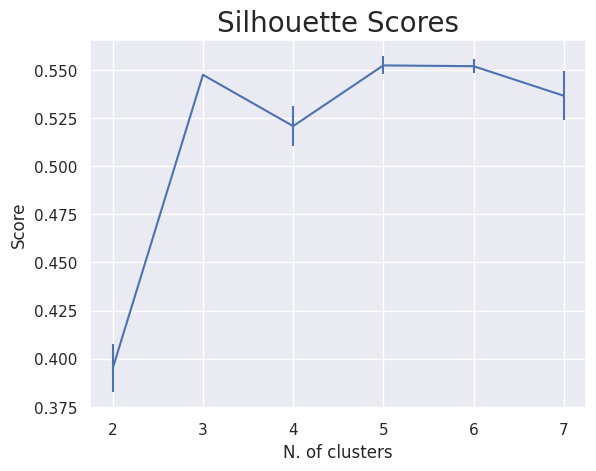

In [142]:
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

In [143]:
def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

In [144]:
n_clusters=np.arange(2, 8)
iterations=20
results=[]
res_sigs=[]
for n in n_clusters:
    dist=[]

    for iteration in range(iterations):
        train, test=train_test_split(X_principal, test_size=0.5)

        gmm_train=GaussianMixture(n, n_init=2).fit(train)
        gmm_test=GaussianMixture(n, n_init=2).fit(test)
        dist.append(gmm_js(gmm_train, gmm_test))
    selec=SelBest(np.array(dist), int(iterations/5))
    result=np.mean(selec)
    res_sig=np.std(selec)
    results.append(result)
    res_sigs.append(res_sig)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names,

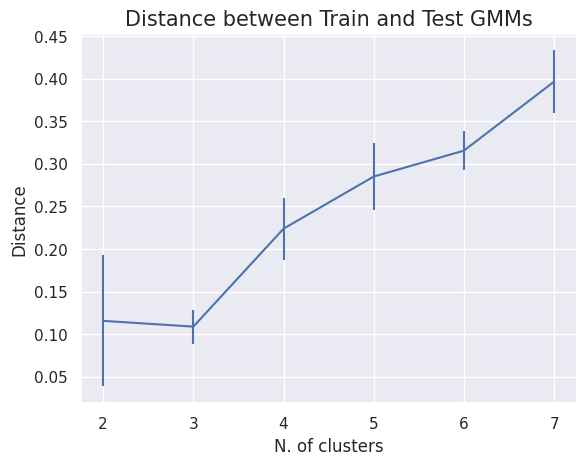

In [145]:
plt.errorbar(n_clusters, results, yerr=res_sigs)
plt.title("Distance between Train and Test GMMs", fontsize=15)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Distance")
plt.show()

In [146]:
n_clusters=np.arange(2, 8)
bics=[]
bics_err=[]
iterations=20
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
        gmm=GaussianMixture(n, n_init=2).fit(X_principal)

        tmp_bic.append(gmm.bic(X_principal))
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)

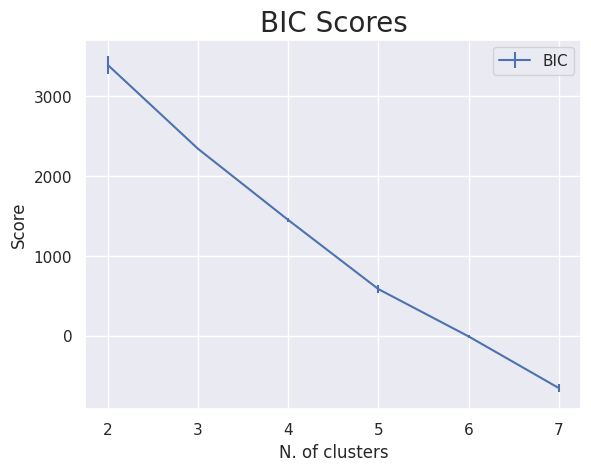

In [147]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

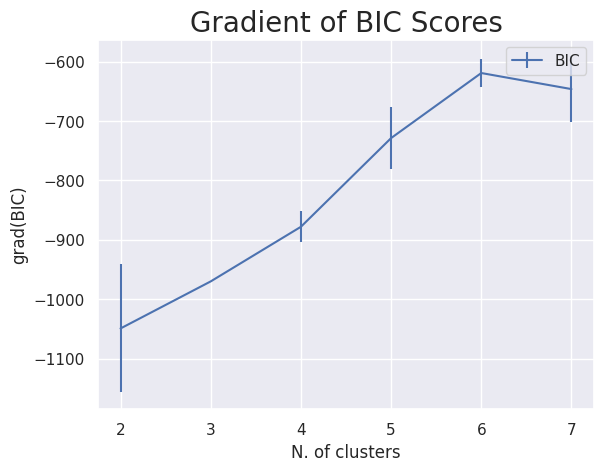

In [148]:
plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

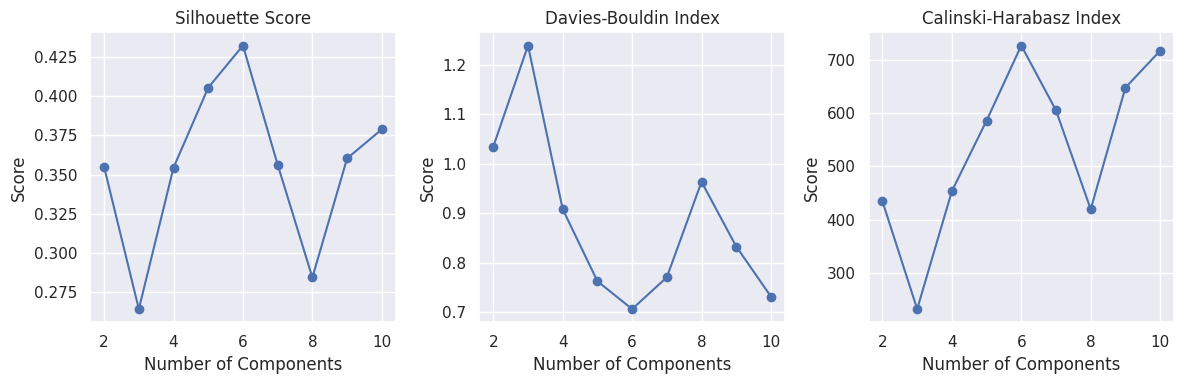

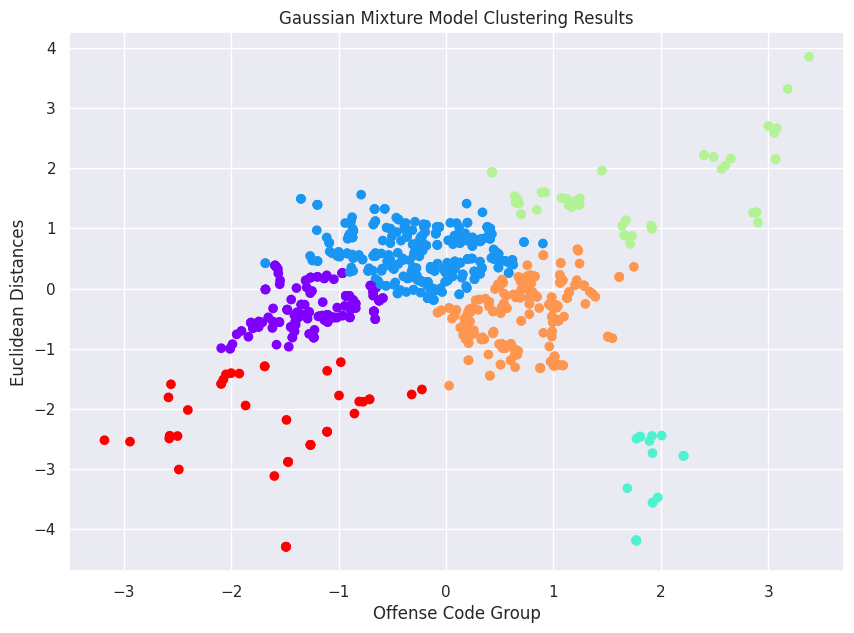

In [159]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# ... (Rest of your code)

# Standardize the data (if not already standardized)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(scaled_df)

# Perform GMM clustering for different values of n_components
n_components_range = range(2, 11)  # You can change this range as needed
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    labels = gmm.fit_predict(data_scaled)

    # Calculate Silhouette Score
    silhouette = silhouette_score(data_scaled, labels)
    silhouette_scores.append(silhouette)

    # Calculate Davies-Bouldin Index
    davies_bouldin = davies_bouldin_score(data_scaled, labels)
    davies_bouldin_scores.append(davies_bouldin)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz = calinski_harabasz_score(data_scaled, labels)
    calinski_harabasz_scores.append(calinski_harabasz)

# Plot the metrics to find the optimal number of components
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.plot(n_components_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Components')
plt.ylabel('Score')

plt.subplot(132)
plt.plot(n_components_range, davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Components')
plt.ylabel('Score')

plt.subplot(133)
plt.plot(n_components_range, calinski_harabasz_scores, marker='o')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Number of Components')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# Choose the optimal number of components based on the metrics
optimal_n_components = n_components_range[np.argmax(silhouette_scores)]

# Perform GMM clustering with the optimal number of components
gmm = GaussianMixture(n_components=optimal_n_components, random_state=0)
labels = gmm.fit_predict(data_scaled)

# # Visual inspection (similar to what you already have)
# plt.figure(figsize=(10, 7))
# plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=labels, cmap='rainbow')
# plt.xlabel('Offense Code Group')
# plt.ylabel('Euclidean Distances')
# plt.title('Gaussian Mixture Model Clustering Results')
# plt.show()
